In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.utils import (
    plot_map, 
    annotate_states_on_map,
    save_mpl_fig,
)
import cmasher as cmr
pd.set_option('display.max_columns', 50)
FIGSAVEDIR = "../figs"
DATAPATH = "../data/individual_browsing_data.csv"

C:\Users\lsys\.conda\envs\gis\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# (fold cell) Load data and collapse to state level
df_ind = (
    pd.read_csv(DATAPATH)
    # Normalize seconds to hours
    .assign(
        duration_adult=lambda df: df.duration_adult / 3600,
        duration_nonadult=lambda df: df.duration_nonadult / 3600,
    )
    # Remove pid7=-1,8,9 (No data, not sure, DK)
    .query("pid7!=-1")  # No data
    .query("pid7!=8")  # not sure
    .query("pid7!=9")  # DK
    # Make inputstate object (for merging later)
    .assign(GEOID=lambda df: df.inputstate.apply(str))
    .assign(GEOID=lambda df: df.GEOID.str.zfill(2))
    # Collapse to state level (inputstate)
    .groupby(["GEOID"])[
        "pid7",
        "rep",
        "prop_adult_visits",
        "prop_adult_duration",
    ]
    .mean()
    .reset_index()
)
df_ind.head()

C:\Users\lsys\AppData\Local\Temp/ipykernel_34972/2566432104.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pd.read_csv(DATAPATH)


,GEOID,pid7,rep,prop_adult_visits,prop_adult_duration
0,-1,1.000000,0.000000,0.000000,0.000000
1,01,4.000000,0.428571,1.082607,0.616572
2,04,3.347826,0.263158,4.729188,5.870035
3,05,4.166667,0.500000,1.374746,4.212617
4,06,3.522222,0.333333,2.698176,3.999551


In [3]:
# (fold cell) Load shape file
DROP_STATES = ['Alaska', 'Hawaii', 'United States Virgin Islands', 'Guam', 'Puerto Rico', 'American Samoa', 'Commonwealth of the Northern Mariana Islands']
gdf_states = (gpd
              .read_file("../data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
              .query("NAME not in @DROP_STATES")
              .assign(centroid=lambda df: df.geometry.centroid)
              # Merge with browsing data & 
              .merge(df_ind, how="left", on="GEOID", validate="1:1")
             )
gdf_states.head(3)

C:\Users\lsys\AppData\Local\Temp/ipykernel_34972/1018054827.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .assign(centroid=lambda df: df.geometry.centroid)


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,centroid,pid7,rep,prop_adult_visits,prop_adult_duration
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",POINT (-89.66521 32.75086),4.090909,0.500000,9.292377,12.457841
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",POINT (-79.37238 35.54153),3.050000,0.285714,1.521769,2.384489
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",POINT (-97.50828 35.58348),4.647059,0.666667,5.390791,8.322337


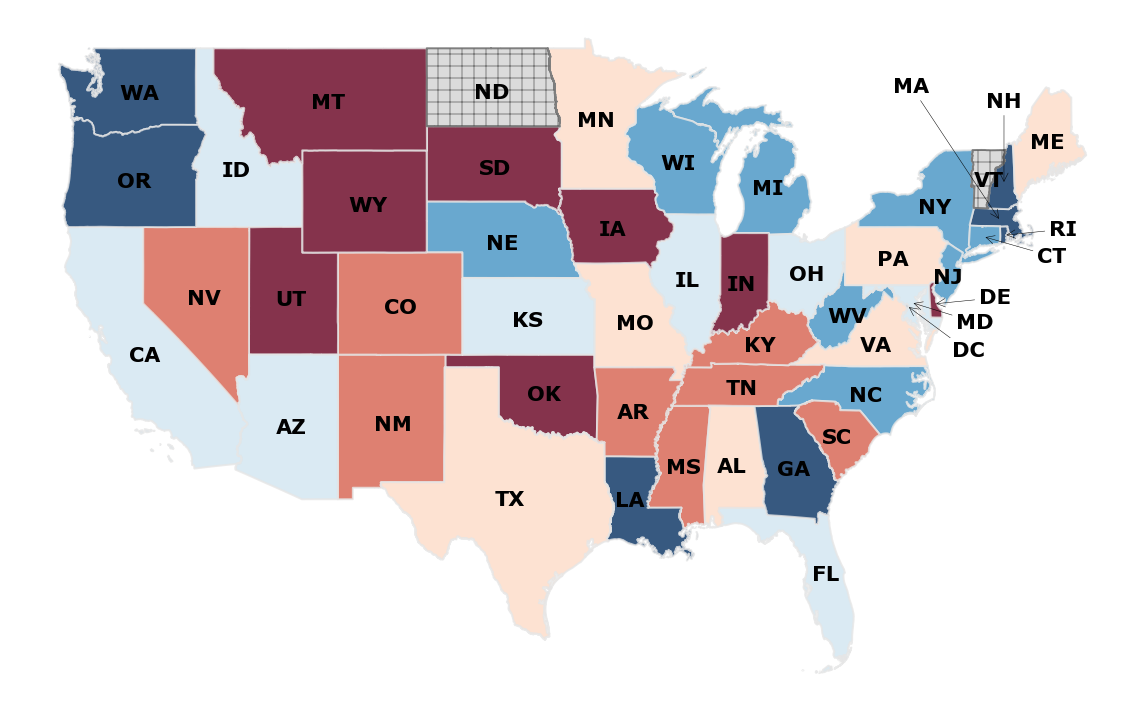

In [4]:
# (fold cell) Plot partisanship
missing_kwds = {
"color": "lightgray",
"hatch": "|-",
"edgecolor": ".4",
"label": "NA",
}
standard_map_opts = {
    "scheme":"quantiles",
    "k":6,
    "alpha":.8,
    "linewidth":2,
    "edgecolor":".9",
    "missing_kwds":missing_kwds,
}
_, ax = plt.subplots(figsize=(16, 10), facecolor="white")
gdf_states.plot(
    "pid7",
    cmap="RdBu_r",
    **standard_map_opts,
    ax=ax,
)
annotate_states_on_map(gdf_states)
plt.axis("off")
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "map_pid7"))

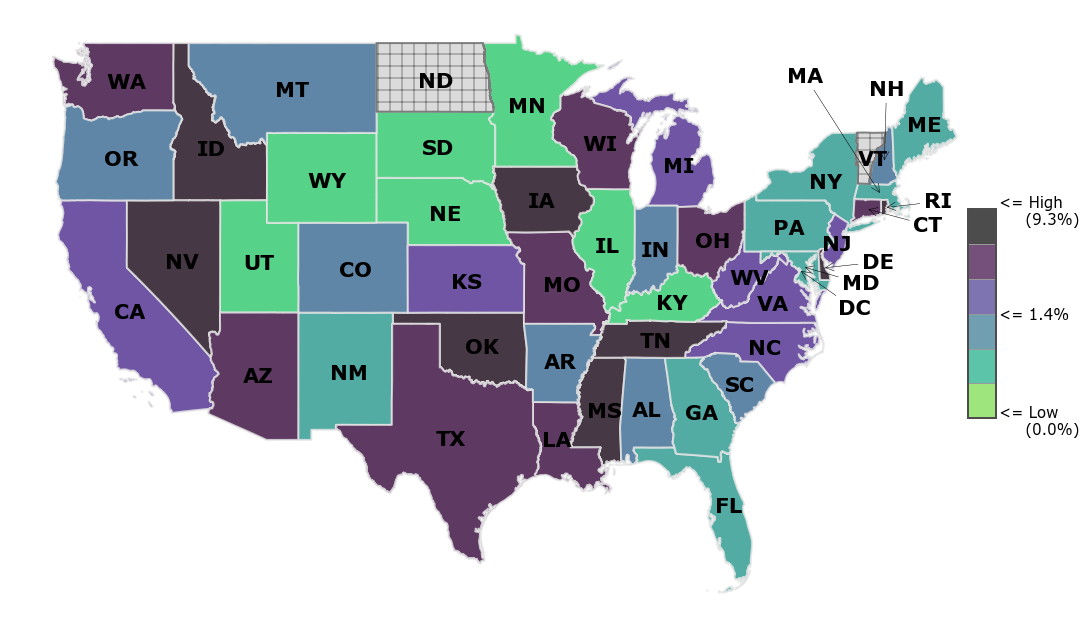

In [5]:
plot_map("prop_adult_visits", gdf_states)  
save_mpl_fig(os.path.join(FIGSAVEDIR, "map_visits"))

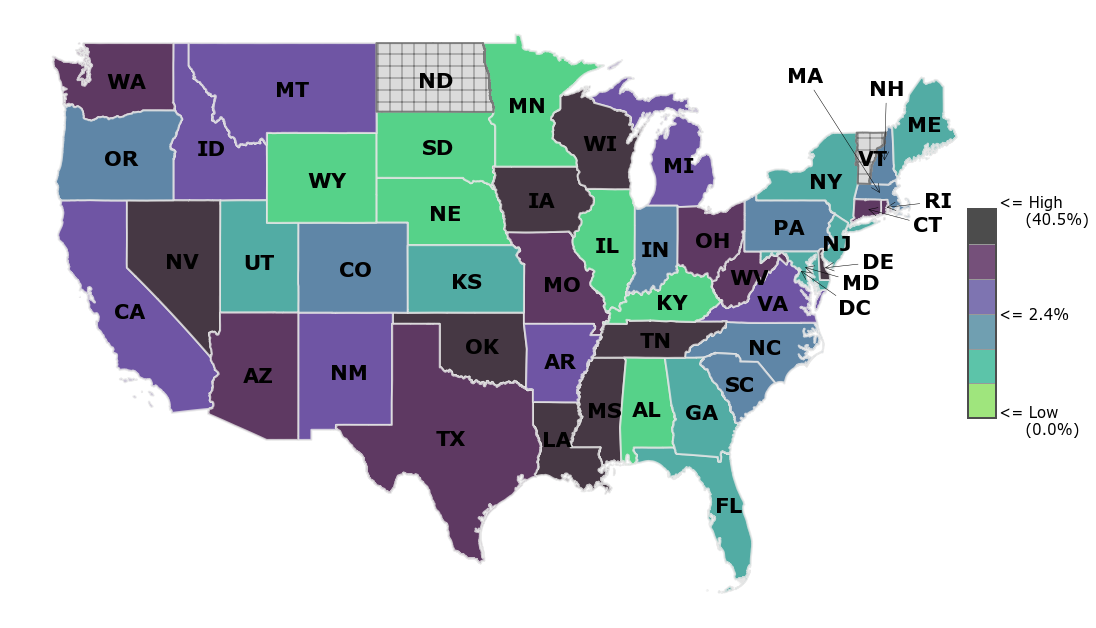

In [6]:
plot_map("prop_adult_duration", gdf_states)
save_mpl_fig(os.path.join(FIGSAVEDIR, "map_duration"))